## Part1-1 loss curve & accuracy

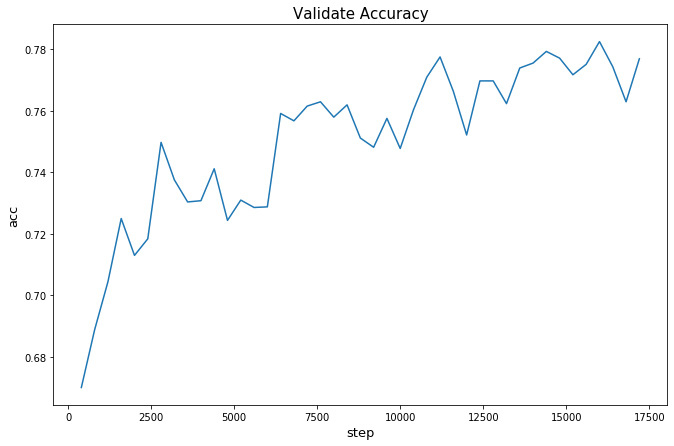

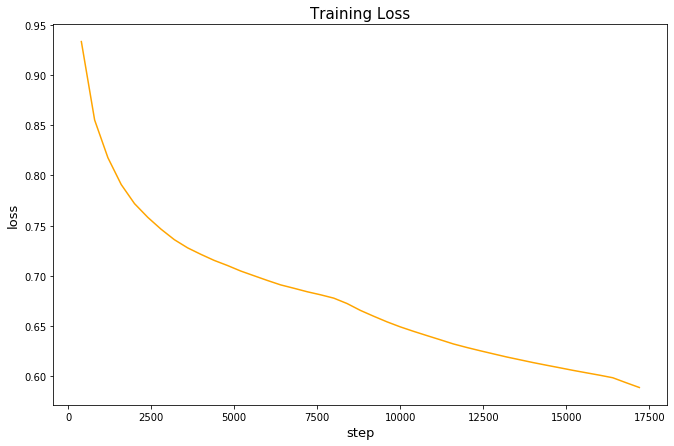

In [13]:
import json
import matplotlib.pyplot as plt


with open('/media/D/DLHLP/hw4/hw4-1/output/logging.txt', 'r') as f:
    log = json.load(f)
    
step, loss, acc = [], [], []
for d in log:
    step.append(d['step'])
    loss.append(d['loss']/d['step'])
    acc.append(d['acc'])

fig = plt.figure(figsize=(11,7))
plt.title('Validate Accuracy', fontsize=15)
plt.xlabel('step', fontsize=13)
plt.ylabel('acc', fontsize=13)
plt.plot(step, acc)
plt.show()

fig = plt.figure(figsize=(11,7))
plt.title('Training Loss', fontsize=15)
plt.xlabel('step', fontsize=13)
plt.ylabel('loss', fontsize=13)
plt.plot(step, loss, color="orange")
plt.show()

# Part2-1 CRF

In [78]:
import torch
from transformers import BertTokenizer, BertForTokenClassification, BertConfig

device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model_config = BertConfig(vocab_size=tokenizer.vocab_size, hidden_size=768, num_hidden_layers=4, num_labels=4)
model = BertForTokenClassification(config=config)
#model = BertForTokenClassification.from_pretrained('bert-base-chinese', num_labels=4)

---

In [42]:
import torch 
import torch.nn as nn

from transformers import BertModel

pretrained_weights = 'bert-base-chinese'

class Model(nn.Module):
    def __init__(self):
        super(Model).__init__()        
        self.bert_embedd = BertModel.from_pretrained(pretrained_weights)
        self.fc = nn.Linear(768, 4)
        
    def forward(self, input_ids):
        last_hidden_states, cls_hidden = self.bert_embedd(input_ids)
        output = self.fc(last_hidden_states)
        return output
    


In [133]:

with open('/media/D/DLHLP/hw4/CWS_dlhlp/train_proc.txt' , 'r') as f:
    data = f.readlines()

label_map = {label: i for i, label in enumerate(['S','B','E','M'])}

sentence, labels = [], []

string, output = [], []
for w in data:
    if w != '\n':
        string.append(w[:w.find("\t")])
        output.append(label_map[w[-2]])
    elif w == '\n':
        sentence.append(string), labels.append(output)
        string, output = [], []

data = {'sentence':sentence, 'labels':labels}

In [ ]:
token_ids = []
label_ids = []

from torch.utils.data import Dataset, DataLoader

class CWS_dataset(Dataset):
    def __init__(self, data_path, tokenizer):
        
        self.tokenizer = tokenizer
        self.label_map = {label: i for i, label in enumerate(['O','S','B','E','M'])}
        
        with open(data_path , 'r') as f:
            data = f.readlines()
            
            sentence, labels = [], []

            string, output = ['[CLS]'], [0]
            for w in data:
                if w != '\n':
                    string.append(w[:w.find("\t")])
                    output.append(label_map[w[-2]])
                elif w == '\n':
                    sentence.append(string+['[SEP]']), labels.append(output+[0])
                    string, output = ['[CLS]'], [0]
                                
            self.data = {'sentence':sentence, 'labels':labels}
            assert len(self.data['sentence'])==len(self.data['labels']) 
    
    def __len__(self):
        assert len(self.data['sentence'])==len(self.data['labels']) 
        return len(self.data['sentence'])
    
    def __getitem__(self, idx):
        return self.data['sentence'][idx], self.data['labels'][idx]
    
    def collate_fn(self, samples):
        tokenizer = self.tokenizer
        
        b_token_ids = []
        b_label_ids = []
        
        ## word to token id
        for sentence, labels in samples:
            token_ids, label_ids = [], []
            for index, word in enumerate(sentence):
                ids = tokenizer.convert_tokens_to_ids(word)
                
                token_ids.append(ids)
                label_ids.append(labels[index])
                
            assert len(token_ids)==len(label_ids)
                
            b_token_ids.append(token_ids)
            b_label_ids.append(label_ids)
            
        ## fix to same length 
        max_length = max([len(token_ids) for token_ids in b_token_ids])
        
        PAD_token = tokenizer.convert_tokens_to_ids('[PAD]')
        for token_ids, label_ids in zip(b_token_ids, b_label_ids):
            token_ids += [PAD_token]*(max_length-len(token_ids))
            label_ids += [0]*(max_length-len(label_ids))
        #print(max_length)
        
        return b_token_ids, b_label_ids
    pass

tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
train_dataset = CWS_dataset('/media/D/DLHLP/hw4/CWS_dlhlp/train_proc.txt', tokenizer)

for i in range(len(train_dataset)):
    batch = [train_dataset[i], train_dataset[-i]]
    batch = train_dataset.collate_fn(batch)
    print(batch)
    input("")

print("finish~")

([[101, 677, 3862, 3855, 691, 2458, 1355, 680, 3791, 1169, 2456, 6392, 1398, 3635, 102], [101, 677, 3862, 3855, 691, 2458, 1355, 680, 3791, 1169, 2456, 6392, 1398, 3635, 102]], [[0, 1, 2, 1, 2, 1, 2, 0, 1, 2, 1, 2, 1, 2, 0], [0, 1, 2, 1, 2, 1, 2, 0, 1, 2, 1, 2, 1, 2, 0]])


In [ ]:
'''
for sentence, labels in zip(data['sentence'],data['labels']):
    
    for word in sentence:
        token_ids.append(tokenizer.tokenize(word, do_lower_case=True))
    
token_ids
'''

In [ ]:
tokenizer.convert_tokens_to_ids("999999999999999asdf999999999")